In [9]:
noise_type = 7
noise_percent = 0.05

In [2]:
import re
import os
import random
import numpy as np
from tqdm import tqdm
from scipy.io import loadmat
import matplotlib.pyplot as plt

import torch
from torchinfo import summary
from torch.utils.data import DataLoader

from models.vae_trainer import VAETrainer

In [3]:
DATASET_PATH = os.path.join(os.getcwd(), 'data')

In [4]:
seed = 37
torch.manual_seed(seed)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
class SensorDataset():
    def __init__(self, data: np.array):
        self.x = self.np2tensor(data)
        
    @staticmethod
    def np2tensor(x):
        return torch.tensor(x, dtype=torch.float32)
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx]

In [6]:
latent_dims = 118
batch_size = 16
epochs = 1000

In [7]:
data_filename = 'data.mat'
data = loadmat(os.path.join(DATASET_PATH, data_filename))
Z = data['Z']
T = len(Z)
train_size = int(T * 0.8)
lr = 1e-1
scheduler = True
es_patience = 10

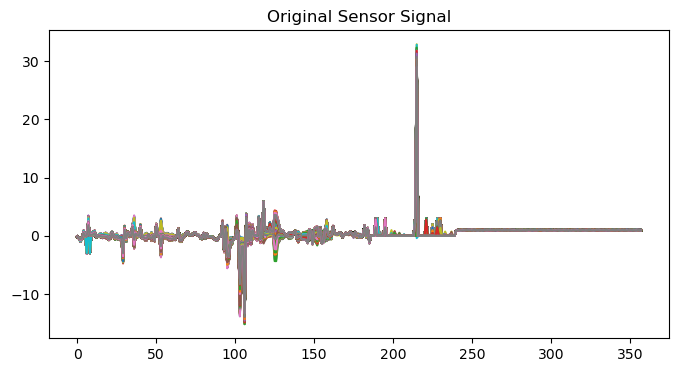

In [8]:
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(Z))
axs.set_title('Original Sensor Signal')
plt.show()

In [10]:
# read attack noise
NOISE_PATH = os.path.join(DATASET_PATH, f'I{noise_type}')
Z_noise = dict()
for filename in tqdm(os.listdir(NOISE_PATH), desc='Reading noise data ... '):
    fname = os.path.join(NOISE_PATH, filename)
    data = loadmat(fname)
    att_type = int(re.findall(r'\d+', filename)[0])
    Z_noise[att_type] = np.array(data['Z'])

Z_noise = dict(sorted(Z_noise.items()))

Reading noise data ... : 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]


In [11]:
Z_noise.keys()

dict_keys([1, 2, 3])

In [12]:
noise_size = int(T * noise_percent)
norm_operation_win = 50
# sample random times after norm_operation_win to add in Z
noise_time = np.random.choice(list(range(norm_operation_win, T)), size=noise_size, replace=False)
# sample attack types to sample a noise
noise_to_add_from = np.random.choice(list(Z_noise.keys()), size=noise_size, replace=True).tolist()
random.shuffle(noise_to_add_from)
# randomly select noises from attack types
noises = []
for _type in noise_to_add_from:
    noise_id = random.sample(range(T), 1)
    noises.append(Z_noise[_type][noise_id])
random.shuffle(noises)
noises = np.concatenate(noises, axis=0)
# add noises to original sensor data Z
Z[noise_time,:] = noises


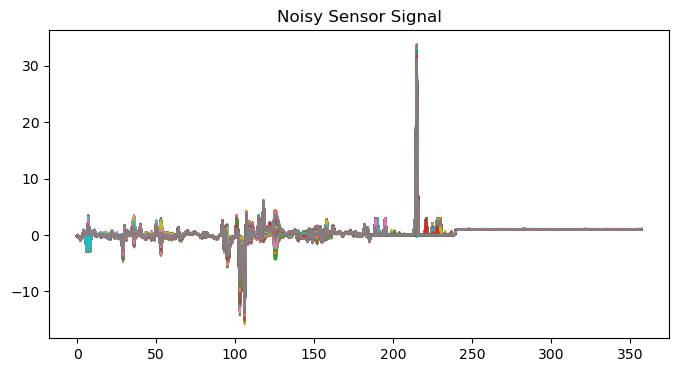

In [13]:
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(Z))
axs.set_title('Noisy Sensor Signal')
plt.show()

In [14]:
Z_train, Z_test = Z[:train_size], Z[train_size:]
training = SensorDataset(Z_train)
test = SensorDataset(Z_test)
train_dl = DataLoader(training, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test)

In [15]:
trainer = VAETrainer(latent_dim=latent_dims, lr=lr, 
                     lr_scheduler=scheduler, es_patience=es_patience,
                     checkpoint_name=f'vae_{int(noise_percent*100)}%.pt', 
                     seed=seed)

Device:  cuda


In [16]:
summary(trainer.vae, (1, 358))

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 358]                  --
├─VariationalEncoder: 1-1                [1, 118]                  --
│    └─Linear: 2-1                       [1, 236]                  84,724
│    └─BatchNorm1d: 2-2                  [1, 236]                  472
│    └─Linear: 2-3                       [1, 118]                  27,966
│    └─Linear: 2-4                       [1, 118]                  14,042
│    └─Linear: 2-5                       [1, 118]                  14,042
├─Decoder: 1-2                           [1, 358]                  --
│    └─Linear: 2-6                       [1, 236]                  28,084
│    └─BatchNorm1d: 2-7                  [1, 236]                  472
│    └─Linear: 2-8                       [1, 358]                  84,846
Total params: 254,648
Trainable params: 254,648
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.00
Forward/b

In [17]:
vae, mse, kl, val_mse, val_kl = trainer.train(train_dl, test_dl, epochs=epochs)

Epoch 1/1000: [MSE: 1.4159], [KL: 1.1145], [Val_MSE: 0.1366], [Val_KL: 0.3788], 
Validation loss decreased (inf --> 0.136621).  Saving model ...
Epoch 2/1000: [MSE: 0.1314], [KL: 0.3676], [Val_MSE: 0.1402], [Val_KL: 0.3615], 
EarlyStopping counter: 1 out of 10
Epoch 3/1000: [MSE: 0.1189], [KL: 0.3658], [Val_MSE: 0.1431], [Val_KL: 0.3648], 
EarlyStopping counter: 2 out of 10
Epoch 4/1000: [MSE: 0.1192], [KL: 0.3638], [Val_MSE: 0.1222], [Val_KL: 0.3662], 
Validation loss decreased (0.136621 --> 0.122220).  Saving model ...
Epoch 5/1000: [MSE: 0.1109], [KL: 0.3626], [Val_MSE: 0.1042], [Val_KL: 0.3622], 
Validation loss decreased (0.122220 --> 0.104212).  Saving model ...
Epoch 6/1000: [MSE: 0.1104], [KL: 0.3616], [Val_MSE: 0.0951], [Val_KL: 0.3618], 
Validation loss decreased (0.104212 --> 0.095101).  Saving model ...
Epoch 7/1000: [MSE: 0.1047], [KL: 0.3611], [Val_MSE: 0.1057], [Val_KL: 0.3616], 
EarlyStopping counter: 1 out of 10
Epoch 8/1000: [MSE: 0.1052], [KL: 0.3605], [Val_MSE: 0.12

In [24]:
def plot_learning(mse, kl, val_mse, val_kl):
    fig, axs = plt.subplots(1,2, figsize=(10,4))
    axs[0].plot(mse, color='r', label='Training')
    axs[0].plot(val_mse, color='b', label='Validation')
    axs[0].set_title('MSE Loss')
    axs[1].plot(kl, color='r', label='Training')
    axs[1].plot(val_kl, color='b', label='Validation')
    axs[1].set_title('KL Loss')
    plt.legend()
    #plt.savefig('./imgMix/mse-kl-mvae.pdf', format='pdf', dpi=1200)
    plt.show()

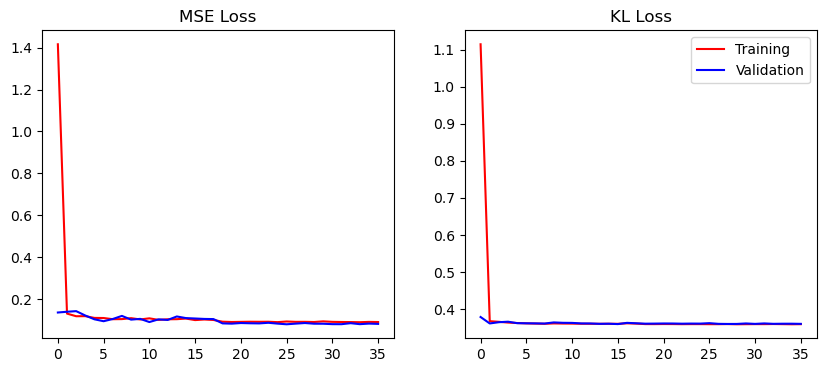

In [25]:
plot_learning(mse, kl, val_mse, val_kl)

In [26]:
vae.eval()
Z = torch.tensor(Z, dtype=torch.float32).to(device)
Z_enc = vae(Z)

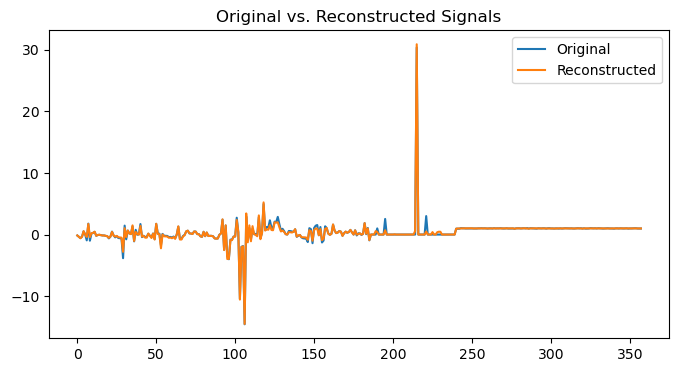

In [27]:
idx = 1001
fig, axs = plt.subplots(figsize=(8,4))
axs.plot(np.transpose(Z[idx,:].cpu().detach().numpy()), label='Original')
axs.plot(np.transpose(Z_enc[idx,:].cpu().detach().numpy()), label='Reconstructed')
axs.set_title('Original vs. Reconstructed Signals')
plt.legend()
plt.show()

In [28]:
vae.eval()
Z_latent = vae.encoder(Z)

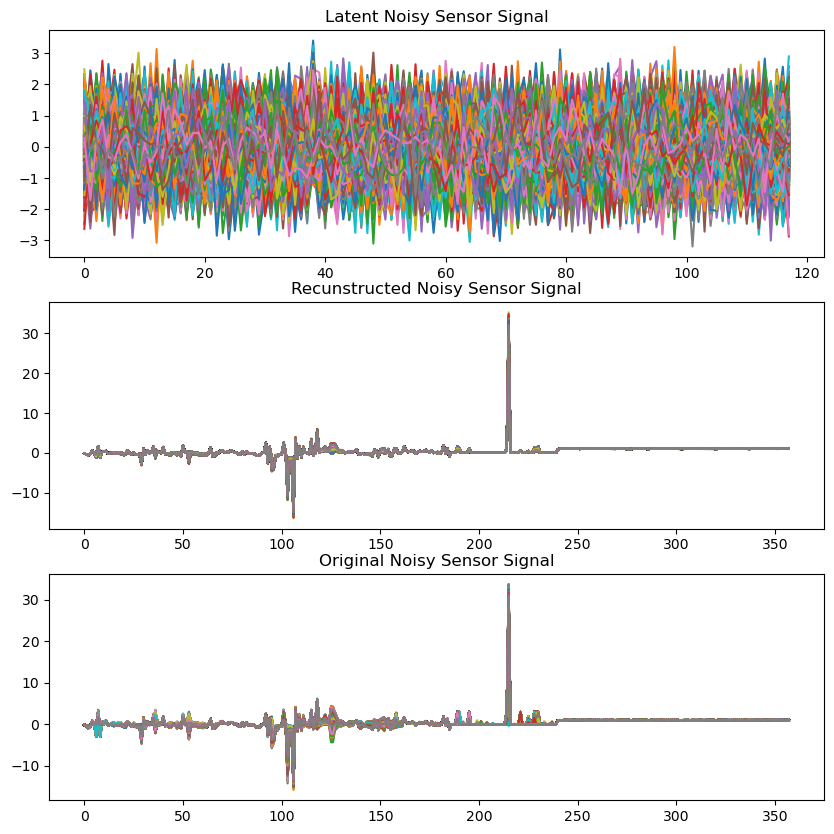

In [29]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(np.transpose(Z_latent.cpu().detach().numpy()))
axs[0].set_title('Latent Noisy Sensor Signal')
axs[1].plot(np.transpose(Z_enc.cpu().detach().numpy()))
axs[1].set_title('Recunstructed Noisy Sensor Signal')
axs[2].plot(np.transpose(Z.cpu().detach().numpy()))
axs[2].set_title('Original Noisy Sensor Signal')
plt.show()

**$t=101$ latent distribution**

In [30]:
vae.eval()
sample_size = 30
signal = Z[100:102]
signal_latent, signal_rec = [], []
for _ in range(sample_size):
    signal_rec.append(vae(signal))
    signal_latent.append(vae.encoder(signal))
signal_latent = torch.stack(signal_latent, dim=0)
signal_rec = torch.stack(signal_rec, dim=0)

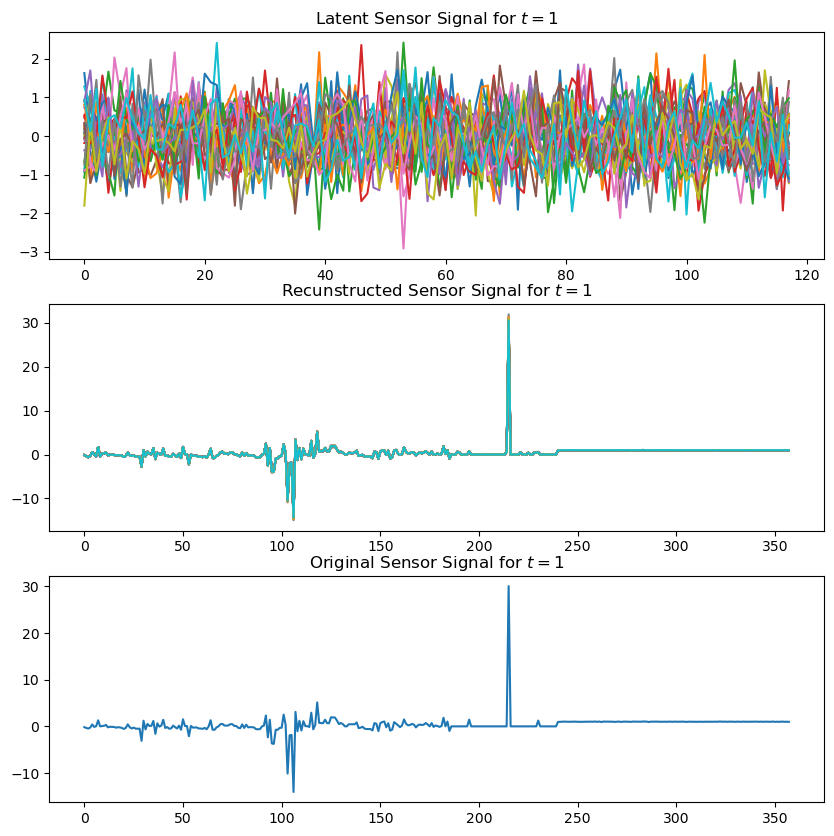

In [31]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))
axs[0].plot(np.transpose(signal_latent.cpu().detach().numpy()[:,0,:]))
axs[0].set_title(r'Latent Sensor Signal for $t=101$')
axs[1].plot(np.transpose(signal_rec.cpu().detach().numpy()[:,0,:]))
axs[1].set_title(r'Recunstructed Sensor Signal for $t=101$')
axs[2].plot(np.transpose(signal.cpu().detach().numpy()[0]))
axs[2].set_title(r'Original Sensor Signal for $t=101$')
plt.show()